In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.datasets import make_blobs
import random as rand

np.random.seed(3)

%matplotlib inline

plot_size   = 15
plot_width  = 16
plot_height = 8

params = {'legend.fontsize': 'large',
          'figure.figsize': (plot_width,plot_height),
          'axes.labelsize': plot_size,
          'axes.titlesize': plot_size,
          'xtick.labelsize': plot_size*0.75,
          'ytick.labelsize': plot_size*0.75,
          'axes.titlepad': 25}
plt.rcParams.update(params)
plt.rcParams.update(params)

In [2]:
num_cities = 21
num_clients = num_cities - 1
num_vehicles = 4
vehicle_payload = 7

# Define pickup and time window constraints
pickup_windows = [(0, 50), (10, 30), (20, 40), (5, 25), (15, 35), (25, 45), (35, 55), (45, 65), (40, 60), (30, 50),
                  (20, 40), (10, 30), (0, 20), (10, 30), (20, 40), (30, 50), (40, 60), (50, 70), (60, 80), (70, 90)]
time_windows = [(0, 100), (20, 60), (30, 70), (40, 80), (10, 50), (20, 60), (30, 70), (40, 80), (50, 90), (60, 100),
                (70, 110), (80, 120), (90, 130), (100, 140), (110, 150), (120, 160), (130, 170), (140, 180), (150, 190),
                (160, 200)]
demands = [0, 3, 4, 2, 5, 3, 4, 2, 4, 3, 2, 5, 4, 3, 5, 4, 3, 2, 3, 5]

<ipython-input-3-ff9de136ada1>:14: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(cities_coord[1:, 0], cities_coord[1:, 1], s=plot_size*2, cmap='viridis');
<ipython-input-3-ff9de136ada1>:15: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(cities_coord[0, 0], cities_coord[0, 1], s=plot_size*4, cmap='viridis');


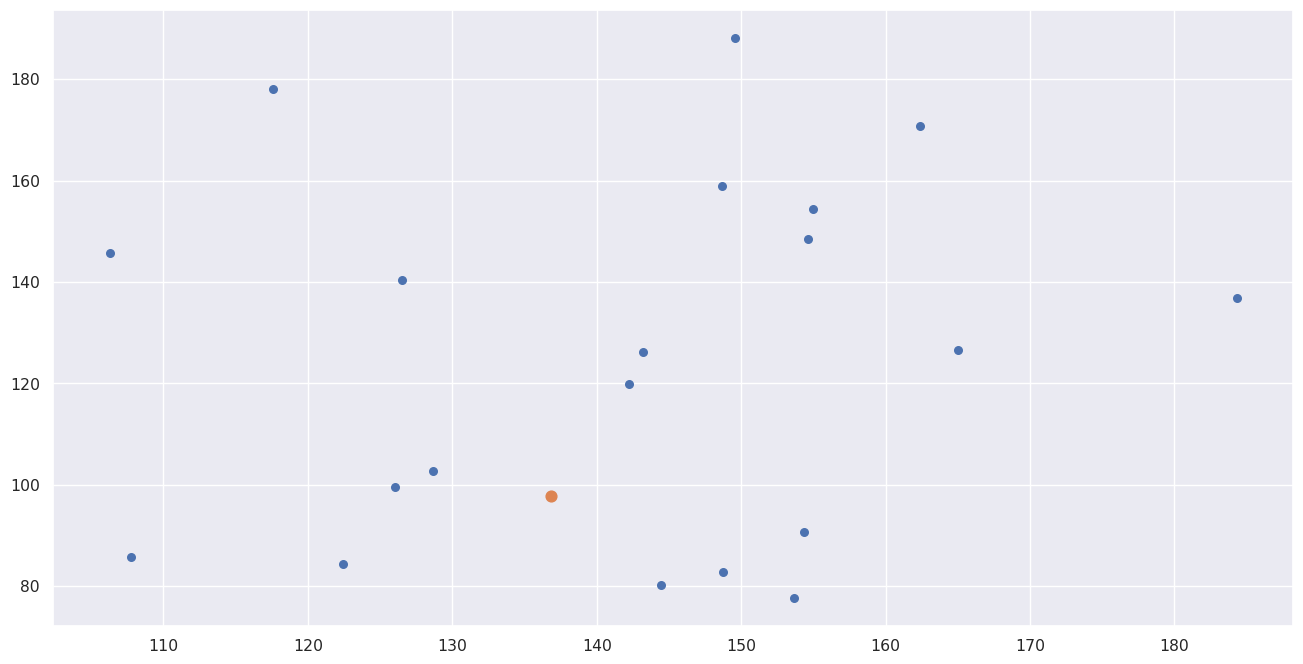

In [3]:
center_box = (100, 200)

cities_coord, _ = make_blobs(n_samples=num_cities,
                           centers=2,
                           cluster_std=20,
                           center_box=center_box,
                           random_state = 2)

all_names = [i for i in range(num_cities)]
client_names = [i for i in range(1, num_cities)]
all_coord_dict = {name: coord for name,coord in zip(all_names, cities_coord)}
client_coord_dict = {name: coord for name,coord in zip(client_names, cities_coord[1:])}

plt.scatter(cities_coord[1:, 0], cities_coord[1:, 1], s=plot_size*2, cmap='viridis');
plt.scatter(cities_coord[0, 0], cities_coord[0, 1], s=plot_size*4, cmap='viridis');

In [4]:
from scipy.spatial import distance

dist_matrix = distance.cdist(cities_coord, cities_coord, 'euclidean')

In [5]:
! pip install deap
from deap import base, creator, tools

tb = base.Toolbox()

creator.create('Fitness_Func', base.Fitness, weights=(-1.0,))
creator.create('Individual', list, fitness=creator.Fitness_Func)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 4.0 MB/s eta 0:00:00


In [6]:
import copy

def chromo_create(_cities_names, _pickup_windows, _time_windows, _demands):
    schedule = copy.deepcopy(_cities_names)
    vehicle = list(np.random.randint(num_vehicles, size=(len(schedule))))
    np.random.shuffle(schedule)
    chromo = [schedule, vehicle]

    return chromo

In [7]:
def chromo_eval(_dist_matrix, _chromo, _pickup_windows, _time_windows, _demands):
    route_set = [[] for _ in range(num_vehicles)]
    for s, v in zip(_chromo[0], _chromo[1]):
        # route_set[v].append(s)
        route_set[v % num_vehicles].append(s)

    dist = 0
    for route in route_set:
        dist += calc_route_cost(_dist_matrix, route)

    penalty = 0
    for route in route_set:
        for i in range(len(route)):
            city = route[i]
            if i == 0:  # depot
                pickup_time = 0
            else:
                pickup_time += _dist_matrix[route[i-1], city]
            if pickup_time < _pickup_windows[city][0]:
                penalty += (_pickup_windows[city][0] - pickup_time) * 1000  # Penalty for early pickup
            if pickup_time > _pickup_windows[city][1]:
                penalty += (pickup_time - _pickup_windows[city][1]) * 1000  # Penalty for late pickup
            if i == len(route) - 1:  # Last city in the route
                arrival_time = pickup_time
            else:
                arrival_time += _dist_matrix[city, route[i+1]]
            if arrival_time < _time_windows[city][0]:
                penalty += (_time_windows[city][0] - arrival_time) * 1000  # Penalty for early arrival
            if arrival_time > _time_windows[city][1]:
                penalty += (arrival_time - _time_windows[city][1]) * 1000  # Penalty for late arrival

    total_demand = sum(_demands[city] for city in _chromo[0])
    if total_demand > vehicle_payload:
        penalty += (total_demand - vehicle_payload) * 10000  # Penalty for exceeding vehicle payload

    return dist + penalty,



def get_route(_chromo):
    route_set = [[] for _ in range(num_vehicles)]
    for s, v in zip(_chromo[0], _chromo[1]):
        #route_set[v % num_vehicles].append(s)
        route_set[v].append(s)
    return route_set


def calc_route_cost(_dist_matrix, _route):
    if not _route:
        return 0
    dist = dist_matrix[_route[-1], 0] + dist_matrix[0, _route[0]]

    for p in range(len(_route) - 1):
        _i = _route[p]
        _j = _route[p + 1]
        dist += _dist_matrix[_i][_j]

    return dist

In [8]:
def crossover(_chromo1, _chromo2):
    cuts = get_chromo_cut()
    partial_crossover(_chromo1[0], _chromo2[0], cuts)

    cuts1 = get_chromo_cut()
    cuts2 = get_chromo_cut(cuts1[2])

    swap_genes(_chromo1[1], _chromo2[1], cuts1, cuts2)


def partial_crossover(_chromo1, _chromo2, cuts):

    size = len(_chromo1)
    p1, p2 = [0] * size, [0] * size

    for i in range(size):
        p1[_chromo1[i] - 1] = i
        p2[_chromo2[i] - 1] = i

    for i in range(cuts[0], cuts[1]):

        temp1 = _chromo1[i] - 1
        temp2 = _chromo2[i] - 1

        _chromo1[i], _chromo1[p1[temp2]] = temp2 + 1, temp1 + 1
        _chromo2[i], _chromo2[p2[temp1]] = temp1 + 1, temp2 + 1

        p1[temp1], p1[temp2] = p1[temp2], p1[temp1]
        p2[temp1], p2[temp2] = p2[temp2], p2[temp1]


def get_chromo_cut(cut_range=None, mutation=False):

    if mutation:
        randrange = num_clients
    else:
        randrange = num_clients + 1

    if cut_range is None:
        cut1 = rand.randrange(randrange)
        cut2 = rand.randrange(randrange)
        if cut1 > cut2:
            tmp = cut2
            cut2 = cut1
            cut1 = tmp
        cut_range = cut2 - cut1
    else:

        cut1 = rand.randrange(num_clients + 1 - cut_range)
        cut2 = cut1 + cut_range
    return cut1, cut2, cut_range


def swap_genes(chrom1, chrom2, cuts1, cuts2):
    tmp = chrom1[cuts1[0]:cuts1[1]]
    chrom1[cuts1[0]:cuts1[1]] = chrom2[cuts2[0]:cuts2[1]]
    chrom2[cuts2[0]:cuts2[1]] = tmp

In [9]:
def mutation(_chromo):
    if np.random.rand() < 0.5:
        swap_gene(_chromo)
    else:
        shuffle_gene(_chromo)


def swap_gene(_chromo):
    cuts = get_chromo_cut(mutation=True)

    if np.random.rand() < 0.5:
        tmp = _chromo[0][cuts[0]]
        _chromo[0][cuts[0]] = _chromo[0][cuts[1]]
        _chromo[0][cuts[1]] = tmp
    else:
        tmp = _chromo[1][cuts[0]]
        _chromo[1][cuts[0]] = _chromo[1][cuts[1]]
        _chromo[1][cuts[1]] = tmp


def shuffle_gene(_chromo):
    cuts = get_chromo_cut(mutation=True)

    if np.random.rand() < 0.5:
        tmp = _chromo[0][cuts[0]:cuts[1]]
        np.random.shuffle(tmp)
        _chromo[0][cuts[0]:cuts[1]] = tmp
    else:
        tmp = _chromo[1][cuts[0]:cuts[1]]
        np.random.shuffle(tmp)
        _chromo[1][cuts[0]:cuts[1]] = tmp

In [10]:
# Feasibility function incorporating pickup and time window constraints
def feasibility(_chromo):
    excess_payload = [vehicle_payload - sum(demands[_] for _ in _chromo[1]) for _ in range(num_vehicles)]
    _vehicle_id = [i for i in range(num_vehicles)]

    while any(_p < 0 for _p in excess_payload):
        v_id = next(i for i, _p in enumerate(excess_payload) if _p < 0)
        available_vehicles = [i for i, e in enumerate(excess_payload) if e > 0]

        if len(available_vehicles) == 0:
            raise ValueError('INFEASIBLE SOLUTION: No available vehicle to accept excess cargo. Increase the number of vehicles or the vehicle payload')

        idx = [i for i, x in enumerate(_chromo[1]) if x == v_id]
        to_vehicle = rand.choice(available_vehicles)
        idx_to_move = rand.choice(idx)
        _chromo[1][idx_to_move] = to_vehicle
        excess_payload[v_id] += demands[_chromo[0][idx_to_move]] - demands[_chromo[0][idx_to_move - 1]]  # Update payload
        excess_payload[to_vehicle] -= demands[_chromo[0][idx_to_move]] - demands[_chromo[0][idx_to_move - 1]]  # Update payload


In [11]:
# Update the toolbox registration
tb.register('indexes', chromo_create, client_names, pickup_windows, time_windows, demands)
tb.register('individual', tools.initIterate, creator.Individual, tb.indexes)
tb.register('population', tools.initRepeat, list, tb.individual)
tb.register('evaluate', chromo_eval, dist_matrix, pickup_windows, time_windows, demands)
tb.register('select', tools.selTournament)
tb.register('mate', crossover)
tb.register('mutate', mutation)
tb.register('feasibility', feasibility)

In [12]:
num_population = 200
num_generations = 1000
prob_crossover = .4
prob_mutation = .6

In [13]:
population = tb.population(n=num_population)

In [14]:
fitness_set = list(tb.map(tb.evaluate, population))
for ind, fit in zip(population, fitness_set):
    ind.fitness.values = fit

IndexError: index 50 is out of bounds for axis 0 with size 21

In [ ]:
best_fit_list = []
best_sol_list = []

best_fit = np.Inf

for gen in range(0, num_generations):

    if (gen % 50 == 0):
        print(f'Generation: {gen:4} | Fitness: {best_fit:.2f}' )

    offspring = tb.select(population, len(population), tournsize=3)
    offspring = list(map(tb.clone, offspring))

    for child1, child2 in zip(offspring[0::2], offspring[1::2]):
        if np.random.random() < prob_crossover:
            tb.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values

    for chromo in offspring:
        if np.random.random() < prob_mutation:
            tb.mutate(chromo)
            del chromo.fitness.values

    for chromo in offspring:
        tb.feasibility(chromo)

    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitness_set = map(tb.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitness_set):
        ind.fitness.values = fit

    population[:] = offspring

    curr_best_sol = tools.selBest(population, 1)[0]
    curr_best_fit = curr_best_sol.fitness.values[0]

    if curr_best_fit < best_fit:
        best_sol = curr_best_sol
        best_fit = curr_best_fit

    best_fit_list.append(best_fit)
    best_sol_list.append(best_sol)

In [ ]:
plt.plot(best_fit_list)
plt.show()

In [ ]:
best_routes = get_route(best_sol)
print(best_routes)

In [ ]:
plt.scatter(cities_coord[1:, 0], cities_coord[1:, 1], s=plot_size*2, cmap='viridis');
plt.scatter(cities_coord[0, 0], cities_coord[0, 1], s=plot_size*4, cmap='viridis');
for i, txt in enumerate(all_names):
    plt.annotate(txt, (cities_coord[i, 0]+1, cities_coord[i, 1]+1))

for r in best_routes:
    route = [0] + r + [0]
    for p in range(len(route) - 1):
        i = route[p]
        j = route[p + 1]
        colour = 'black'
        plt.arrow(cities_coord[i][0],
                  cities_coord[i][1],
                  cities_coord[j][0] - cities_coord[i][0],
                  cities_coord[j][1] - cities_coord[i][1],
                  color=colour)

plt.show()
